In [4]:
import pandas as pd

data = pd.read_csv("./data/fifa_20.csv")

In [5]:
data.columns

Index(['short_name', 'age', 'height_cm', 'weight_kg', 'nationality',
       'club_name', 'league_name', 'overall', 'potential', 'value_eur',
       'wage_eur', 'preferred_foot', 'international_reputation', 'weak_foot',
       'skill_moves', 'work_rate', 'release_clause_eur', 'player_tags', 'pace',
       'shooting', 'passing', 'dribbling', 'defending', 'physic', 'gk_diving',
       'gk_handling', 'gk_kicking', 'gk_reflexes', 'gk_speed',
       'gk_positioning', 'player_traits', 'attacking_crossing',
       'attacking_finishing', 'attacking_heading_accuracy',
       'attacking_short_passing', 'attacking_volleys', 'skill_dribbling',
       'skill_curve', 'skill_fk_accuracy', 'skill_long_passing',
       'skill_ball_control', 'movement_acceleration', 'movement_sprint_speed',
       'movement_agility', 'movement_reactions', 'movement_balance',
       'power_shot_power', 'power_jumping', 'power_stamina', 'power_strength',
       'power_long_shots', 'mentality_aggression', 'mentality_interce

In [6]:
goalkeeper_drop = ['gk_handling', 'gk_kicking', 'gk_reflexes', 'gk_speed','gk_positioning', 'gk_diving', 'goalkeeping_diving',
                  'goalkeeping_handling', 'goalkeeping_kicking','goalkeeping_positioning', 'goalkeeping_reflexes',
                  'bmi']#, 'value_eur', 'wage_eur']

data.drop(goalkeeper_drop, axis=1, inplace=True)

In [7]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(data, test_size=.2, train_size=.8, random_state=6)

In [8]:
train.shape, test.shape

((12977, 56), (3245, 56))

In [9]:
X_train, y_train = train.drop('overall', axis=1), train['overall']
X_test, y_test = test.drop('overall', axis=1), test['overall']

In [10]:
X_train, X_test = X_train.iloc[:, 1:], X_test.iloc[:, 1:]

# baseline

In [11]:
baseline = [y_train.mean()] * len(X_test)

In [12]:
from sklearn.metrics import mean_squared_error

print(f"RMSE : {mean_squared_error(y_test, baseline)}")

RMSE : 46.91775088923753


# Model Training

- baseline --> 
- simple linear model / Random Forest / XGboost / lightGBM

In [13]:
from sklearn.pipeline import Pipeline, make_pipeline
from category_encoders import OrdinalEncoder, TargetEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import lightgbm as lgb



In [14]:
models = []
models.append(
              ('LinearRegression', 
               Pipeline([('ordinal', OrdinalEncoder()),
                         ('scaled', StandardScaler()),                          
                         ('LR', LinearRegression())])
              )
            )
models.append(
    
              ('RandomForestRegressor', 
               Pipeline([('ordinal', OrdinalEncoder()),
                         ('scaled', StandardScaler()),                          
                         ('RF', RandomForestRegressor())])
              )
            )
models.append(
             ('lightGMB',
              Pipeline([('ordinal', OrdinalEncoder()),
                        ('scaled', StandardScaler()),
                        ('lgb', lgb.LGBMRegressor())
                       ]))
            )
models.append(
              ('XGBoost', 
               Pipeline([('ordinal', OrdinalEncoder()),
                         ('scaled', StandardScaler()), 
                         ('xgb', XGBRegressor())])
              )
            )


In [15]:
for name, model in models:
    model.fit(X_train, y_train)
    
    prediction = model.predict(X_test)
    #predict_proba = model.predict_proba(X_test)
    loss = mean_squared_error(y_test, prediction, squared=False)
    
    print(f"{name}: {loss}")

LinearRegression: 0.6734850858046537
RandomForestRegressor: 0.38373932632727115
lightGMB: 0.35819349417890534
XGBoost: 0.3154813179697147


### best model XGBoost

In [16]:
model.named_steps['xgb']

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

# Hyperparameter Tuning

In [17]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

In [18]:
import warnings
warnings.filterwarnings("ignore")

In [19]:
distributions = {
    'xgb__max_depth' : randint(3, 10),
    #'xgb__max_leaf_nodes' : randint(1, 5),
    'xgb__n_estimators' : randint(1, 500),
    'xgb__learning_rate' : [0.01, 0.05, 0.1, 0.5, 1.0],
}
clf = RandomizedSearchCV(model, param_distributions=distributions,
                        n_iter=5, scoring='neg_root_mean_squared_error',
                        )

clf.fit(X_train, y_train)

RandomizedSearchCV(estimator=Pipeline(steps=[('ordinal',
                                              OrdinalEncoder(cols=['nationality',
                                                                   'club_name',
                                                                   'league_name',
                                                                   'preferred_foot',
                                                                   'work_rate',
                                                                   'positions'],
                                                             mapping=[{'col': 'nationality',
                                                                       'data_type': dtype('O'),
                                                                       'mapping': Bosnia Herzegovina       1
Russia                   2
Switzerland              3
England                  4
Ghana                    5
                      ... 
Mauritius           

In [46]:
pd.DataFrame(clf.cv_results_).sort_values(by='rank_test_score').T

,2,1,0,4,3
mean_fit_time,0.264884,0.247262,1.55647,0.199384,0.547718
std_fit_time,0.0292689,0.0302469,0.0822007,0.00372822,0.0158424
mean_score_time,0.010193,0.00801115,0.0104363,0.00745583,0.00827184
std_score_time,0.00343991,0.000570909,0.000791843,0.000231023,0.000239019
param_xgb__learning_rate,0.5,0.05,0.01,0.05,0.01
param_xgb__max_depth,7,4,9,6,6
param_xgb__n_estimators,46,116,408,73,249
params,"{'xgb__learning_rate': 0.5, 'xgb__max_depth': ...","{'xgb__learning_rate': 0.05, 'xgb__max_depth':...","{'xgb__learning_rate': 0.01, 'xgb__max_depth':...","{'xgb__learning_rate': 0.05, 'xgb__max_depth':...","{'xgb__learning_rate': 0.01, 'xgb__max_depth':..."
split0_test_score,-0.403103,-0.549371,-1.19743,-1.65104,-5.45384
split1_test_score,-0.412574,-0.5675,-1.19325,-1.64796,-5.4498


In [20]:
clf.best_score_

-0.40419163533787383

In [21]:
best_model = clf.best_estimator_
pred = best_model.predict(X_test)
mean_squared_error(y_test, pred, squared=False)

0.3635860302564271

# Shap

In [22]:
import shap
import matplotlib.pyplot as plt

In [23]:
son = X_train[(X_train['nationality'] == 'Korea Republic') & (X_train['club_name'] == 'Tottenham Hotspur')]
enc = OrdinalEncoder()
son_enc = enc.fit_transform(son)
son_enc

,age,height_cm,weight_kg,nationality,club_name,league_name,potential,value_eur,wage_eur,preferred_foot,...,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_marking,defending_standing_tackle,defending_sliding_tackle,positions,posotion_ability
34,26,183,78,1,1,1,88,60000000,180000,1,...,39,88,81,71,87,0.0,34,33,1,88


In [24]:
enc = OrdinalEncoder()
scale = StandardScaler()
shap_data = enc.fit_transform(X_train)
shap_data = scale.fit_transform(shap_data)
shap_data = pd.DataFrame(shap_data, columns=X_train.columns, index=X_train.index)

In [25]:
y_train.loc[34] # son overall

87

In [26]:
son_enc = shap_data.loc[[34]]
explainer = shap.TreeExplainer(best_model.named_steps['xgb'])
shap_values = explainer.shap_values(son_enc)

shap.initjs()
shap.force_plot(
    base_value=explainer.expected_value, 
    shap_values=shap_values,
    features=son_enc,
    #matplotlib=True, show=False
)
#plt.savefig("son_forceplot.png",dpi=150, bbox_inches='tight')

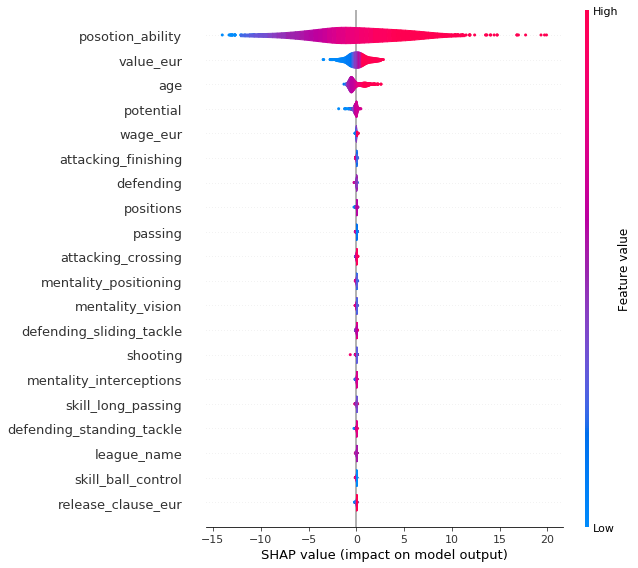

In [27]:
shap_values = explainer.shap_values(shap_data.iloc[3:700])
shap.summary_plot(shap_values, shap_data.iloc[3:700], plot_type='violin', show=False)
plt.savefig("featImp_violin.png",dpi=150, bbox_inches='tight')

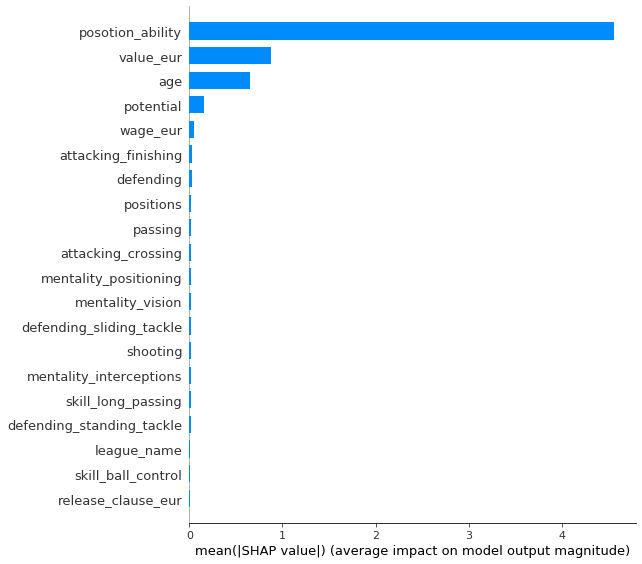

In [28]:
plt.figure()
shap.summary_plot(shap_values, shap_data.iloc[3:700], plot_type='bar', show=False)
plt.savefig("featImp_bar.png",dpi=150, bbox_inches='tight')

In [29]:
messi = X_train[(X_train['nationality'] == 'Argentina') & (X_train['club_name'] == 'FC Barcelona')]
messi

,age,height_cm,weight_kg,nationality,club_name,league_name,potential,value_eur,wage_eur,preferred_foot,...,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_marking,defending_standing_tackle,defending_sliding_tackle,positions,posotion_ability
0,32,170,72,Argentina,FC Barcelona,Spain Primera Division,94,95500000,575000,Left,...,40,94,94,75,96,0.0,37,26,RW,94


In [30]:
y_train.loc[0] # messi overall

94

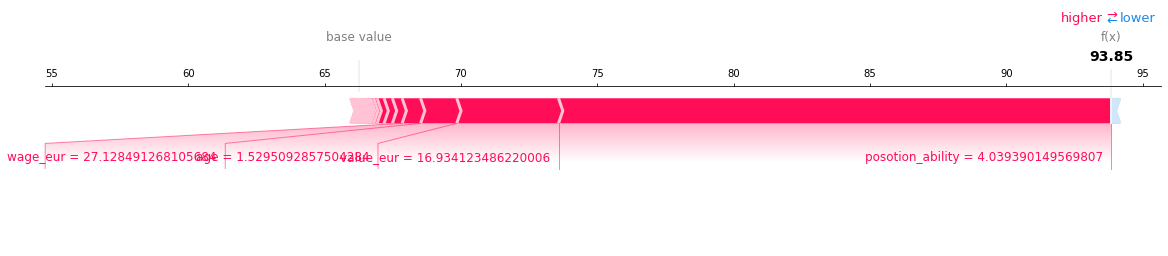

In [31]:
encode = OrdinalEncoder()
messi_enc = shap_data.loc[[0]]

explainer = shap.TreeExplainer(best_model.named_steps['xgb'])
shap_values = explainer.shap_values(messi_enc)

shap.initjs()
shap.force_plot(
    base_value=explainer.expected_value, 
    shap_values=shap_values,
    features=messi_enc,
    matplotlib=True, show=False
)
plt.savefig("messi_forceplot.png",dpi=150, bbox_inches='tight')

In [32]:
y_train.loc[16148]

49

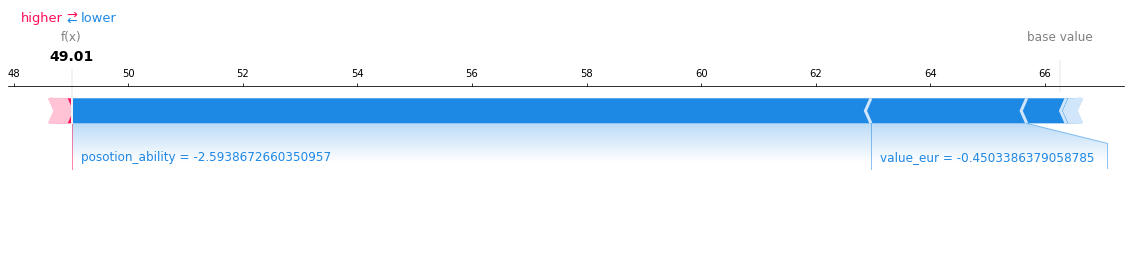

In [33]:
greek = X_train[(X_train['nationality'] == 'Greece') & (X_train['club_name'] == 'Plymouth Argyle')]

encode = OrdinalEncoder()
g_enc = shap_data.loc[[16148]]

explainer = shap.TreeExplainer(best_model.named_steps['xgb'])
shap_values = explainer.shap_values(g_enc)

shap.initjs()
shap.force_plot(
    base_value=explainer.expected_value, 
    shap_values=shap_values,
    features=g_enc,
    matplotlib=True, show=False
)
plt.savefig("gr_forceplot.png",dpi=150, bbox_inches='tight')

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


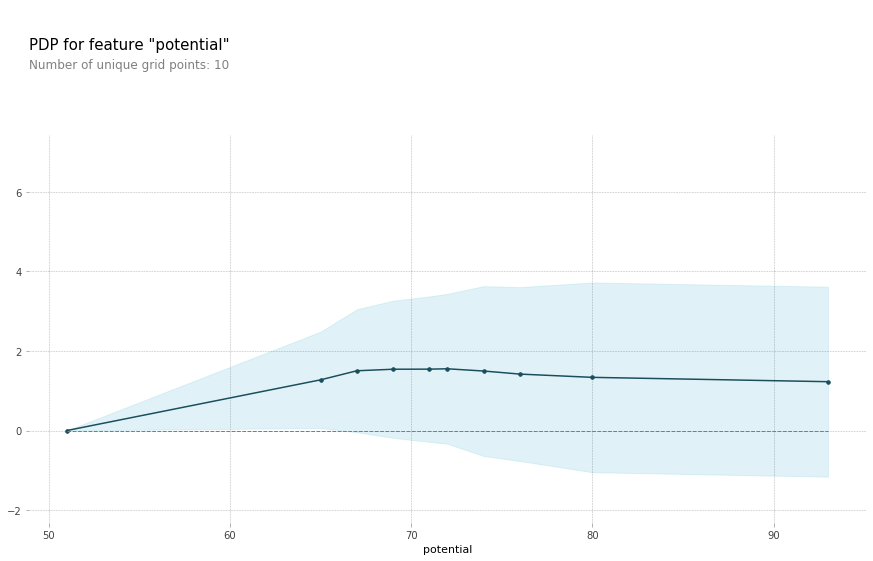

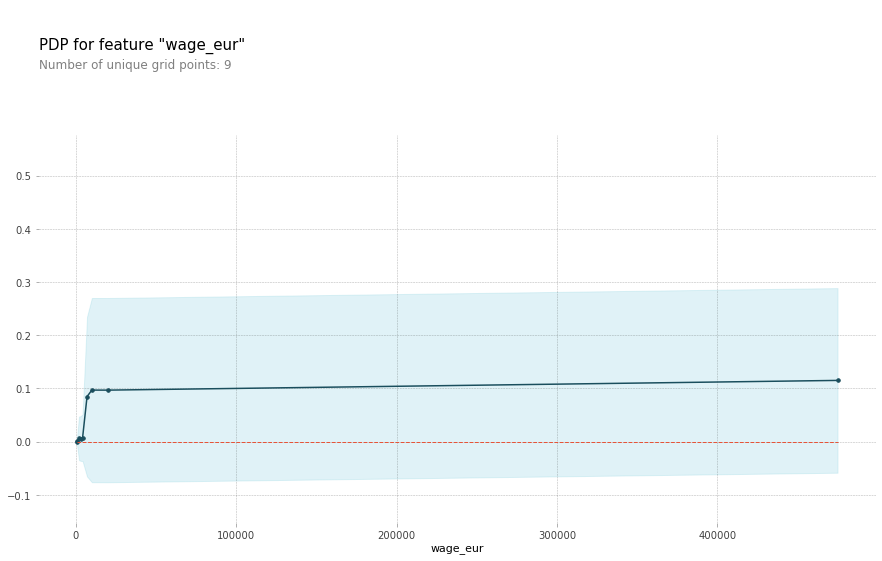

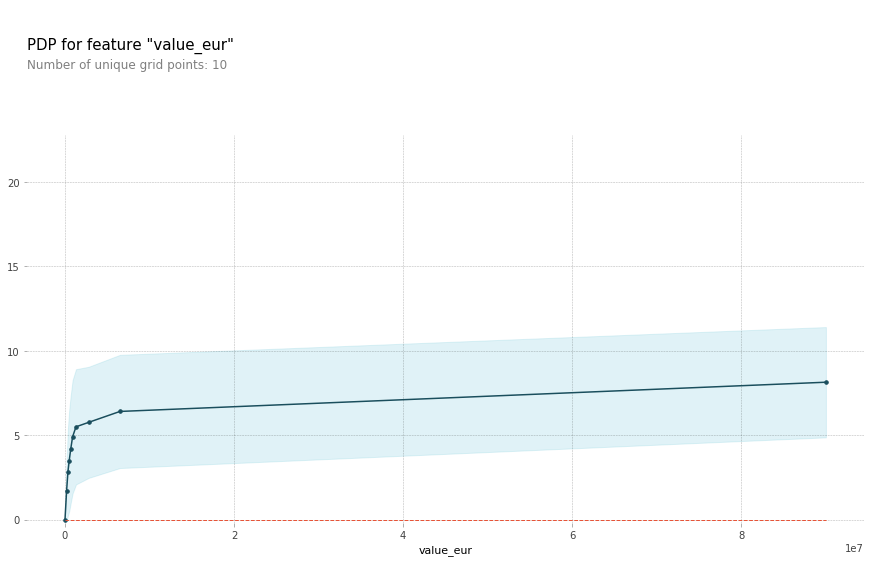

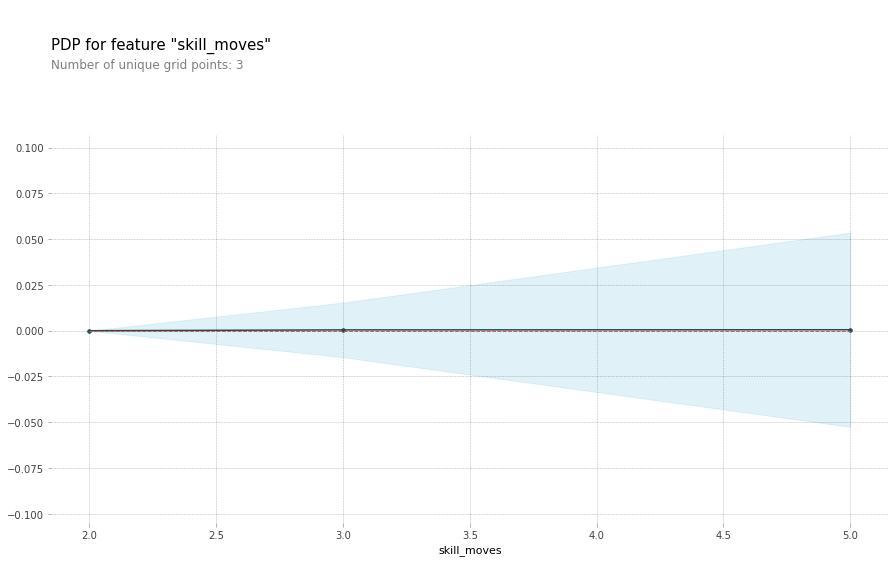

In [34]:
from pdpbox.pdp import pdp_isolate, pdp_plot

features = ['potential', 'wage_eur', 'value_eur', 'skill_moves']
for feat in features:
    isolated = pdp_isolate(
        model=best_model, 
        dataset=X_test, 
        model_features=X_test.columns, 
        feature=feat,
        grid_type='percentile', # default='percentile', or 'equal'
        num_grid_points=10 # default=10
    )
    pdp_plot(isolated, feature_name=feat);

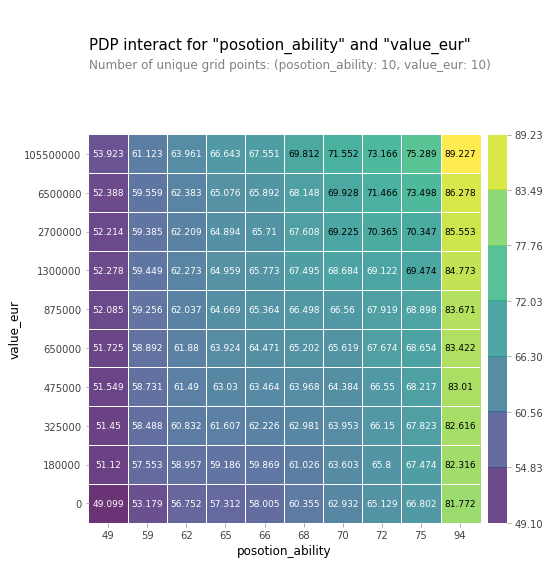

In [48]:
from pdpbox.pdp import pdp_interact, pdp_interact_plot
fe = ['posotion_ability', 'value_eur']

interaction = pdp_interact(
    model=best_model, 
    dataset=X_train, 
    model_features=X_train.columns, 
    features=fe
)

pdp_interact_plot(interaction, plot_type='grid', feature_names=fe);

In [36]:
X_train.columns

Index(['age', 'height_cm', 'weight_kg', 'nationality', 'club_name',
       'league_name', 'potential', 'value_eur', 'wage_eur', 'preferred_foot',
       'international_reputation', 'weak_foot', 'skill_moves', 'work_rate',
       'release_clause_eur', 'player_tags', 'pace', 'shooting', 'passing',
       'dribbling', 'defending', 'physic', 'player_traits',
       'attacking_crossing', 'attacking_finishing',
       'attacking_heading_accuracy', 'attacking_short_passing',
       'attacking_volleys', 'skill_dribbling', 'skill_curve',
       'skill_fk_accuracy', 'skill_long_passing', 'skill_ball_control',
       'movement_acceleration', 'movement_sprint_speed', 'movement_agility',
       'movement_reactions', 'movement_balance', 'power_shot_power',
       'power_jumping', 'power_stamina', 'power_strength', 'power_long_shots',
       'mentality_aggression', 'mentality_interceptions',
       'mentality_positioning', 'mentality_vision', 'mentality_penalties',
       'mentality_composure', 'defe

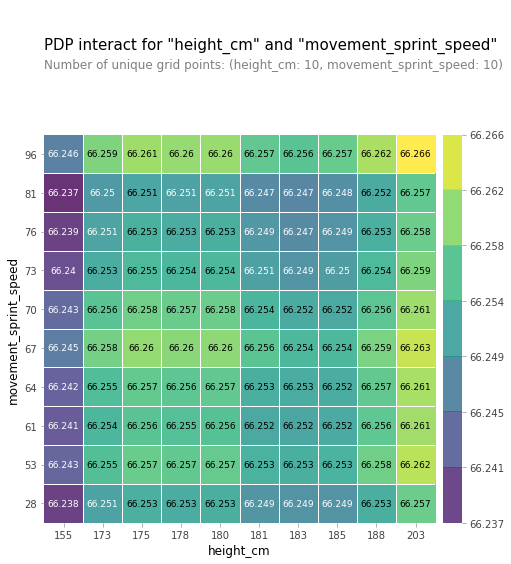

In [37]:
fe = ['height_cm', 'movement_sprint_speed']

interaction = pdp_interact(
    model=best_model, 
    dataset=X_train, 
    model_features=X_train.columns, 
    features=fe
)

pdp_interact_plot(interaction, plot_type='grid', feature_names=fe);

### Intro
1. fifa20 데이터를 통해 선수의 overall을 예측할 것
1. overall은 선수의 전체적인 능력치를 한눈에 보여주는 stat
1. overall 예측을 통해 더 나은 선수들을 영입하고 좋은 팀을 만들 수 있게 한다

### EDA
1. wage와 overall도 정비례관계
1. 유럽의 4대 리그가 연봉을 가장 많이받고 그중에서도 영국 프리미어 리그는 2위와도 큰 격차를 보임
1. 게임상에서 보여지는 선수 능력치는 6개가 있다. (radar plot ㄱㄱ)
1. 이 외에도 개인기, 밸런스 다양한 mentality stat들이 있다.  
    --> 게임상에서 보여지지 않음. 따라서 좋은 선수를 고르는데 한정된 정보만 사용
1. 유저들이 중요하게 보는 속도(pace)와 overall의 관계에 대해 먼저 본다  
    --> 비례하는 모습이지만 전체 능력치가 높다면 그중하나인 속력이 높은건 당연할지도


### Model training
1. baseline으로 linear model을 사용하고 randomforest / lightgbm / xgboost를 비교해본다
1. train data는 무작위로 8:2로 나눔, rmse로 평가
1. 

### Conclusion
1. test set의 RMSE 값은 0.29
1. visualize를 통해 wage, value가 overall과 높은 양의 상관관계라고 볼 수 있음 
    - 당연한 결과일듯, 좋은선수는 높은 주급과 높은 가치를 가질것
1. 키와 sprint_speed의 관계 --> 180과 speed 70 부근에서 가장 overall이 높음
    - 하나로 극단적인 수치를 가지면 다른쪽에서 능력치가 깎여 overall 낮아지는 것으로 예측
1. 모델이 어떤 결과를 보여주는 지 손흥민 선수에 대한 데이터 보겠음  
    - 게임상 overall은 87이지만 모델은 92.8로 예측
    - position_ability와 value_eur이 대부분 결정짓는다. 
    - 실제로 손흥민은 유저들에게 사용 체감이 좋다고 좋은 평을 듣는 카드이다.
    - 실제 overall보다 높게 예측됐다면 체감이 좋은 선수라고 할 수 있을까? -- 추후연구 ㄱ

In [38]:
data.describe()

,age,height_cm,weight_kg,overall,potential,value_eur,wage_eur,international_reputation,weak_foot,skill_moves,...,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_marking,defending_standing_tackle,defending_sliding_tackle,posotion_ability
count,16222.000000,16222.000000,16222.000000,16222.000000,16222.000000,1.622200e+04,16222.000000,16222.000000,16222.000000,16222.000000,...,16222.000000,16222.000000,16222.000000,16222.000000,16222.000000,16222.000000,16222.0,16222.000000,16222.000000,16222.000000
mean,25.112995,180.464369,74.409197,66.346197,71.695290,2.587177e+06,10038.774504,1.103995,3.000986,2.536494,...,59.376033,50.027185,54.953890,55.506658,51.932129,60.359327,0.0,51.783134,49.507397,67.289977
std,4.530792,6.459039,6.699278,6.844129,6.080724,5.649824e+06,21619.331207,0.379777,0.637774,0.627538,...,14.311820,18.843521,14.547748,12.800911,12.414492,10.215876,0.0,19.024498,19.008372,6.637319
min,16.000000,155.000000,50.000000,48.000000,49.000000,0.000000e+00,500.000000,1.000000,1.000000,2.000000,...,10.000000,10.000000,11.000000,12.000000,11.000000,27.000000,0.0,10.000000,10.000000,49.000000
25%,21.000000,176.000000,70.000000,62.000000,67.000000,3.750000e+05,2000.000000,1.000000,3.000000,2.000000,...,50.000000,33.000000,47.000000,47.000000,42.000000,53.000000,0.0,35.000000,32.000000,63.000000
50%,25.000000,180.000000,74.000000,66.000000,71.000000,7.500000e+05,4000.000000,1.000000,3.000000,2.000000,...,61.000000,55.000000,57.000000,57.000000,52.000000,61.000000,0.0,58.000000,56.000000,67.000000
75%,28.000000,185.000000,79.000000,71.000000,76.000000,2.300000e+06,9000.000000,1.000000,3.000000,3.000000,...,70.000000,65.000000,65.000000,65.000000,61.000000,68.000000,0.0,67.000000,65.000000,72.000000
max,42.000000,203.000000,110.000000,94.000000,95.000000,1.055000e+08,575000.000000,5.000000,5.000000,5.000000,...,95.000000,92.000000,95.000000,94.000000,92.000000,96.000000,0.0,92.000000,90.000000,94.000000


In [50]:
data[fe].corr()

,posotion_ability,value_eur
posotion_ability,1.000000,0.662292
value_eur,0.662292,1.000000
